In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from mlxtend.evaluate import cochrans_q


In [96]:
laligadf = pd.read_pickle('laligadfmod')
laligadf = laligadf.drop('index',axis=1)
laligadf = laligadf.drop('xg',axis=1)
y=laligadf['outcome']
X=laligadf.loc[:, laligadf.columns!='outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.5, 
                                                    shuffle=True, stratify=y)
X_test.columns

Index(['x', 'y', 'end_x', 'end_y', 'aerial_won', 'follows_dribble',
       'first_time', 'open_goal', 'deflected', 'team_Almería',
       ...
       'type_Free Kick', 'type_Open Play', 'type_Penalty',
       'technique_Backheel', 'technique_Diving Header',
       'technique_Half Volley', 'technique_Lob', 'technique_Normal',
       'technique_Overhead Kick', 'technique_Volley'],
      dtype='object', length=576)

# Histogram based Gradient Boosting

In [66]:
boost = HistGradientBoostingClassifier(learning_rate=0.1,random_state=42,verbose=10)
param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7,8],
               'min_samples_leaf': [35,36,37,38,39,40,41,42]}]
hisgs = GridSearchCV(estimator=boost,
                    n_jobs=2,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10)
hisgs.fit(X_train,y_train) 
print('Best Accuracy: %.2f%%' % (hisgs.best_score_*100))
print('Best Params: %s' % hisgs.best_params_)
print('Test Accuracy: %.2f%%' % (hisgs.best_estimator_.score(X_test,y_test)*100))  

TypeError: __init__() got an unexpected keyword argument 'class_weight'

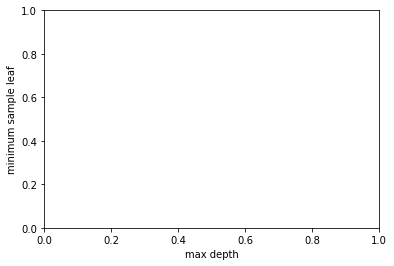

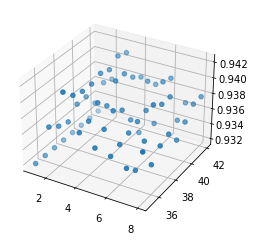

In [57]:

import matplotlib.pyplot as plt
import numpy as np
m = 8
n = 8
X = np.reshape(hisgs.cv_results_['param_max_depth'].data,[n,m])
Y = np.reshape(hisgs.cv_results_['param_min_samples_leaf'].data,[n,m])
Z = np.reshape(hisgs.cv_results_['mean_test_score'],[n,m])
plt.xlabel('max depth')
plt.ylabel('minimum sample leaf')
#plt.zlabel('test score')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X,Y,Z)


#### After replacing the min samples leaf, we found 38 to be the best and max depth did not really change much as we changed it around.

# Next we will look at Random Forest

In [97]:
Rforest = RandomForestClassifier(random_state=42, class_weight='balanced')
Rforest.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [98]:
#https://github.com/rasbt/stat451-machine-learning-fs21/blob/main/07-ensembles/code/07-05_random-forests.ipynb
param_grid = [{'n_estimators': [100,200,300,400],
              'criterion': ['gini','entropy']}]
rgs = GridSearchCV(estimator=Rforest,
                param_grid=param_grid,
                n_jobs=-1,
                cv=10)
rgs.fit(X_train,y_train) 
print('Best Accuracy: %.2f%%' % (rgs.best_score_*100))
print('Best Params: %s' % rgs.best_params_)
print('Test Accuracy: %.2f%%' % (rgs.best_estimator_.score(X_test,y_test)*100)) 

Best Accuracy: 91.91%
Best Params: {'criterion': 'entropy', 'n_estimators': 200}
Test Accuracy: 92.18%


In [76]:
param_grid = [{'n_estimators': [303,304,305,306,307],
              'criterion': ['gini','entropy']}]
rgs = GridSearchCV(estimator=Rforest,
                param_grid=param_grid,
                n_jobs=-1,
                cv=10)
rgs.fit(X_train,y_train) 
print('Best Accuracy: %.2f%%' % (rgs.best_score_*100))
print('Best Params: %s' % rgs.best_params_)
print('Test Accuracy: %.2f%%' % (rgs.best_estimator_.score(X_test,y_test)*100)) 

Best Accuracy: 92.35%
Best Params: {'criterion': 'entropy', 'n_estimators': 305}
Test Accuracy: 92.71%


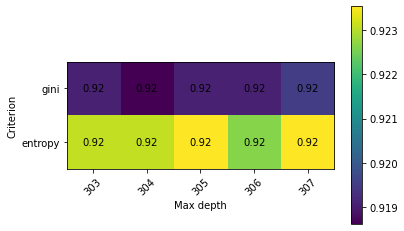

In [80]:
from mlxtend.plotting import heatmap
import numpy as np
grid = np.zeros((2, 5))
grid[0, :] = rgs.cv_results_['mean_test_score'][:5]
grid[1, :] = rgs.cv_results_['mean_test_score'][5:]


heatmap(grid, 
        column_names=[303,304,305,306,307], 
        row_names=['gini', 'entropy'])
plt.ylabel('Criterion')
plt.xlabel('Max depth')
plt.show()

#### We have looked at a few ensemble methods and thought knn could also be useful in this project.

# NCA
#### We have individual players as a column so we thought reducing dimensionality would help in predicting goals.

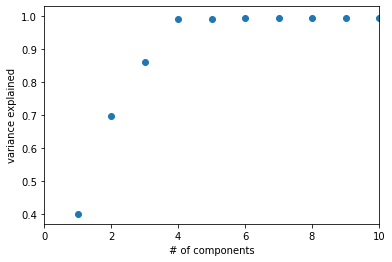

In [81]:
#source: https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Here we looked for the least amount of principal components to explain the most amount of explained variance.
mod = PCA(n_components=len(X_test.columns))
mod.fit(X_train,y_train)
a=mod.explained_variance_ratio_.cumsum() #variance explained
b=range(1,len(X_test.columns)+1) #num of components
plt.xlim([0,10])
plt.xlabel('# of components')
plt.ylabel('variance explained')
plt.scatter(b,a)

#### Based off the graph, there wasn't much improvement in explained variance after 4 principal components so 4 components seem best. 

In [83]:
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=4, random_state=42),
)
knn = KNeighborsClassifier()

param_grid = [{'n_neighbors': [43,44,45,46,47]}]

kgs = GridSearchCV(estimator = knn, param_grid=param_grid, cv=10,refit=True,scoring='accuracy')

nca.fit(X_train, y_train)

kgs.fit(nca.transform(X_train),y_train)

acc_knn = kgs.score(nca.transform(X_test), y_test)

print(kgs.best_params_)
print(kgs.best_score_)

{'n_neighbors': 46}
0.9039662698412698


# Logistic Regression
#### Since the target is either goal or no goal logistic regression would work here

In [1]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42,verbose=10,class_weight='balanced')
logreg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [15]:
param_grid = [{'C': [0.1,0.5,1]}]
lgs = GridSearchCV(estimator=logreg,
                  param_grid=param_grid,
                  cv=10,
                  n_jobs=2)
lgs.fit(X_train,y_train)
print('best parameters:', lgs.best_params_)
print('best accuracy')
print('Best test accuracy: ', lgs.best_estimator_(X_test,y_test)*100)


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/matthewvoss/opt/anaconda3/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/matthewvoss/opt/anaconda3/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [6]:
import xgboost as xg
xgclass = xg.XGBClassifier()
xgclass.fit(X_train,y_train)
xgclass.score(X_test,y_test)

/Users/matthewvoss/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9364444444444444

In [39]:

test_accuracy_his = accuracy_score(y_true=y_test, y_pred=hisgs.predict(X_test))*len(X_test)
test_accuracy_nca = accuracy_score(y_true=y_test, y_pred=kgs.predict(nca.transform(X_test)))*len(X_test)
test_accuracy_random = accuracy_score(y_true=y_test, y_pred=rgs.predict(X_test))*len(X_test)
hisright=0
kright=0
rfright=0
for i in len(X_test):
    his_pred = hisgs.predic(X_test.iloc[i]) #predict individual hist
    knn_pred = kgs.predict(X_test.iloc[i]) #predict individual knn
    rand_pred = rgs.predict(X_test.iloc[i]) #predict individual random forest
    if(y_test.iat[i]==knn_pred): #histogram
        hisright = hisright+1
    if(y_test.iat[i]==knn_pred):
        kright=kright+1
    if(y_test.iat[i]==rand_pred):
        rfright=rfright+1
    
    
    

NameError: name 'hisgs' is not defined

In [93]:
y_model_1 = hisgs.predict(X_test)
y_model_2 = kgs.predict(nca.transform(X_test))
y_model_3 = rgs.predict(X_test)
y_test1 = np.array(y_test)
q, p_value = cochrans_q(y_test1, 
                        y_model_1, 
                        y_model_2, 
                        y_model_3)

print('Q: %.3f' % q)
print('p-value: %.3f' % p_value)
#poggers

import numpy as np
from mlxtend.evaluate import mcnemar_table

# The correct target (class) labels
y_target = y_test1

tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_model_1, 
                   y_model2=y_model_3)

print(tb)
#more poggers

from mlxtend.evaluate import mcnemar

chi2, p = mcnemar(ary=tb, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p)

Q: 85.090
p-value: 0.000
[[2032   81]
 [  54   83]]
chi-squared: 5.007407407407407
p-value: 0.025239078018325235


# Failed attempts

In [ ]:
#https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
#X_new = SelectKBest(chi2, k=50).fit_transform(X,y)
laligadf = pd.read_pickle('laligadfmod')
laligadf = laligadf.drop('index',axis=1)
y=laligadf['outcome']
X=laligadf.loc[:, laligadf.columns!='outcome']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, random_state=123, test_size=0.5, 
                                                    shuffle=True, stratify=y)
rf = RandomForestClassifier(random_state=42, n_estimators=100, criterion='entropy')
model = SelectFromModel(rf,prefit=True)
X_new = model.transform(X)

#### This code did not work, since the features had names and it didn't make much sense to reduced the number of features like this if some players or teams were cut it may negatively affect our model.

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
boost = GradientBoostingClassifier(learning_rate=0.1,random_state=42,verbose=10)
boost.get_params().keys()
param_grid  = [{'max_depth': [1,2,3,4,5,None],
               'min_samples_leaf': [5,10,15,20,25,30],
               'n_estimators': [100,200,300,400,500]}]
gs = GridSearchCV(estimator=boost,
                    n_jobs=2,
                    param_grid=param_grid,
                    scoring='accuracy',)
gs.fit(X_train,y_train) 
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params: %s' % gs.best_params_)
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test,y_test)*100))

#### Looking at the scikit learn API, it says do not use this for larger datasets. 